This notebook will contain similar code from ```Deriv.ipynb``` and ```Main.ipynb``` to learn from a solved process.

# Heat Diffusion on a Graph

Heat on regular surfaces diffuses in this manner:

$$
    \frac{\partial H}{\partial t} = k \frac{\partial^2 H}{\partial x ^2 } 
$$

and on a graph, the Laplacian operator on the surface changes to the Laplacian Matrix, which mirrors the averaging of immediate neighbour nodes of any given node.

Thus, the normalised "Heat" vector $\vec{s}$ has the dynamics:

$$
    \frac{d \vec{s}}{d t} =  - L \vec{s}(t)
$$

Which gives us the unique solution 

$$
    \vec{s}(t) = e^{-Lt} \vec{s}(0) 
$$

where 
$$
e^{-Lt} = \sum_{n=0}^{\infty} \frac{(-Lt)^n}{n!}
$$

which can be calculated better using:

$$
    L = V \Lambda_{l} V ^{-1} \\

$$


$$
    e^{-Lt} = \sum_{n=0}^{\infty} \frac{(-Lt)^n}{n!} = V  \sum_{n=0}^{\infty} \frac{(-\Lambda_l t)^n}{n!} V^{-1}
$$


$$
    e^{-Lt} = V  e^{- \Lambda_{l} t } V^{-1}
$$


In [1]:
#  importing required libraries
%pylab inline
import pandas as pd
import time
import matlab
import matlab.engine
import pickle as pkl 
MATLAB = matlab.engine.start_matlab()

Populating the interactive namespace from numpy and matplotlib


In [2]:
from utils3 import *
from tqdm import tqdm

### Forward simulation
There is no *forward* simulation in this particular dynamic because it is a completely analytically determined system. This would just require us to sample the values at different points and recalculate the Laplacian that has been used.

Scheme:

- $\vec{s}(0)$ is generated randomly. The $e^{-Lt}$ is calculated at different times using the relation $e^{-Lt} = V e^{- \Lambda_l t} V^{-1}$  


In [3]:
N = 10
# T = 1000
d, a = Store(N)
# d, a  = "./Deg.pkl", "./Adj.pkl"
D, A = pkl.load(open(d,"rb")), pkl.load(open(a,"rb"))
L = D - A
ewL, eVL = linalg.eig(L)

np.random.seed(100)
s0 = randn(N,)
dt = 0.001

In [4]:
M0 = lambda x: dot(-1*D, x)
M1 = lambda x: ones(len(x))
M2 = lambda x: dot(A, x)

In [5]:
SampleswoN = []
Samples = []
# Samples.append(SNR_adder(s0,6))
SampleswoN.append(s0)

j = 0
temp = ones(N,)

while norm(SampleswoN[j]-temp) > 1e-5:
    j = j+1
    temp = dot(dot(dot(eVL, diag(exp(-ewL*dt*j))), eVL.T), s0)
    SampleswoN.append(temp)
    temp = SampleswoN[j-1]

del temp
T = len(SampleswoN) 

In [6]:
TRAJ = s0.reshape(N,1)
SNR = 10

for i in range(1,T):
    TRAJ = np.append(TRAJ,SampleswoN[i].reshape(N,1),axis=1)

In [7]:
Noisy_Traj = SNR_adder(TRAJ[0,:],SNR).reshape(1,len(SampleswoN))

for i in range(1,N):
    Noisy_Traj = np.append(Noisy_Traj, SNR_adder(TRAJ[i,:],SNR).reshape(1,len(SampleswoN)), axis =0)

for i in range(len(SampleswoN)):
    Samples.append(Noisy_Traj[:,i])

1243

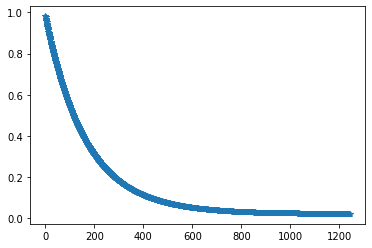

In [8]:
X0 = [(Samples[i])[4] for i in range(len(Samples))]
plot(X0,'*')
len(X0)

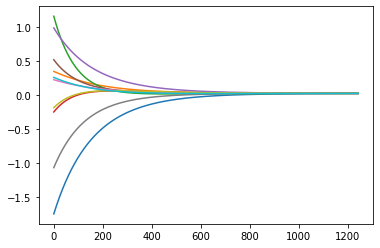

In [9]:
for j in range(N):
    plot([(Samples[i])[j] for i in range(len(SampleswoN))])

In [29]:
MATLAB.workspace['t'] = matlab.int32([T])
for j in range(N):
    ee = matlab.double([(Samples[i])[j] for i in range(len(SampleswoN))])
    MATLAB.workspace['ee'] = ee
    MATLAB.eval("plot(0:0.001:1.242,ee,linewidth=1); hold on; grid on;", nargout=0)

MATLAB.xlabel("Time (t)")
MATLAB.ylabel("Heat value")


In [26]:
k = 1
samples = [Samples[k*i] for i in range(T//k)]
derivs = [(samples[i+1] - samples[i])/(k*dt) for i in range(T//k - 1)]

# samples = [Samples[k*i] for i in range(T-k)]
# derivs = [(samples[i+1] - samples[i])/(k*dt) for i in range(T-k-1)]

In [27]:
# plot([(derivs[i])[1] for i in range(T-k-1)])
# plot([(samples[i])[1] for i in range(T-k)])

In [28]:
# M = T-k-1
M = T//k -1
V = zeros((N,M))
U = zeros((N,M))

for ind in range(M):
    V[:,ind] = derivs[ind] + dot(D,samples[ind])
    U[:,ind] = samples[ind] 

In [29]:
Bigu = U_synth(reshape(U[:,0], (N,1)))
vV  = V[:,0]
j = 1
ranks = []

for j in tqdm(range(1,M)):
    Uu = U_synth(reshape(U[:,j], (N,1)))
    Bigu = append(Bigu, Uu, axis=0)
    ranks.append(linalg.matrix_rank(Bigu))
    vV = append(vV, V[:,j], axis = 0)

# while linalg.matrix_rank(Bigu) < int(N*(N-1)//2):
#     Uu = U_synth(reshape(U[:,j], (N,1)))
#     Bigu = append(Bigu, Uu, axis=0)
#     ranks.append(linalg.matrix_rank(Bigu))
#     vV = append(vV, V[:,j], axis = 0)
#     j += 1

100%|██████████| 1148/1148 [00:16<00:00, 69.76it/s]


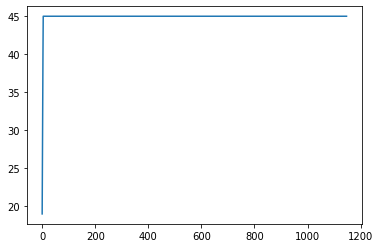

In [30]:
plot(ranks)

In [31]:
linalg.matrix_rank(Bigu)

45

In [32]:
Adj_Le = matricizer(dot(pinv(Bigu), vV))

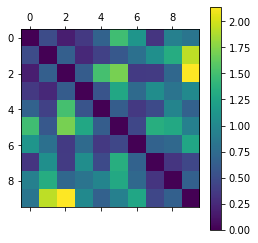

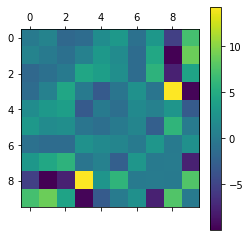

In [33]:
matshow(A)
colorbar()
matshow(Adj_Le)
colorbar()

In [34]:
linalg.cond(Bigu)

390324.36224814

In [41]:
norm(vectorizer(A) - vectorizer(Adj_Le))/(norm(vectorizer(A)))

4.790107648760799

1) Add seed to make every process reproducible
2) https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8439913
3) https://web.media.mit.edu/~xdong/paper/tsipn17.pdf

### Tikhonov regularization

In [36]:
A_TR = matricizer((inv(dot(Bigu.T, Bigu) + 0.11*eye((N*(N-1))//2)).dot(Bigu.T)).dot(vV))

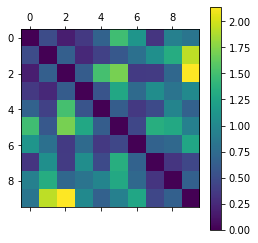

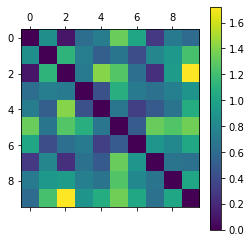

In [37]:
matshow(A)
colorbar()
matshow(A_TR)
colorbar()

In [38]:
norm(vectorizer(A) - vectorizer(A_TR))/(norm(vectorizer(A)))

0.2852302761461072

In [39]:
def Thiko(lm):
    A_lm = matricizer((inv(dot(Bigu.T, Bigu) + lm*eye((N*(N-1))//2)).dot(Bigu.T)).dot(vV))
    return A_lm 

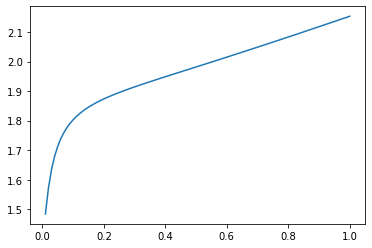

In [40]:
j = np.linspace(0.01,1,100)
YY = [norm(vectorizer(A) - vectorizer(Thiko(lm))) for lm in np.linspace(0.01,1,100)]
min(YY)
plot(j,YY)